**Importing the data from Kaggle**

In [1]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (2).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [2]:
!kaggle datasets download -d hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images

melanoma-skin-cancer-dataset-of-10000-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip melanoma-skin-cancer-dataset-of-10000-images.zip

**Importing the Dependencies**

In [4]:
import os
import numpy as np
import cv2 as cv
from sklearn.preprocessing import LabelEncoder
from keras.layers import Conv2D, MaxPool2D, Flatten, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from keras.models import Sequential
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from keras.applications.vgg16 import VGG16
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [5]:
def input_data(folder_path, output_data):    #importing the data into the output_data list
  for dirs in os.listdir(folder_path):
    class_name = dirs
    new_path = os.path.join(folder_path, class_name)
    for img in os.listdir(new_path):
      img_arr = cv.imread(os.path.join(new_path, img), cv.IMREAD_GRAYSCALE)
      resize = cv.resize(img_arr, (128,128))
      output_data.append([resize, class_name])
  return output_data

In [6]:
train_data = input_data("/content/melanoma_cancer_dataset/train", [])
test_data = input_data("/content/melanoma_cancer_dataset/test", [])

In [7]:
np.random.shuffle(train_data)   #shuffling the data
np.random.shuffle(test_data)

In [8]:
train_images = []              #separating the image and labels from the train_data list
train_labels = []
for features, labels in train_data:
  train_images.append(features)
  train_labels.append(labels)

In [9]:
test_images = []    #separating the image and labels from the test_data list
test_labels = []
for features, labels in test_data:
  test_images.append(features)
  test_labels.append(labels)

In [10]:
label_enc = LabelEncoder()           # encoding the labels 
train_labels = label_enc.fit_transform(train_labels)
test_labels = label_enc.transform(test_labels)

In [11]:
train_images = np.array(train_images)    #converting the images and labels into numpy array
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [12]:
train_images = train_images/255    # normalizing the image pixels
test_images = test_images/255

In [13]:
train_images = np.expand_dims(train_images, axis=3)      # adding a dimension on the images
test_images = np.expand_dims(test_images, axis=3)

In [14]:
print(f"Shape of the train images {train_images.shape}")
print(f"Shape of the train labels {train_labels.shape}")
print(f"Shape of the test images {test_images.shape}")
print(f"Shape of the test labels {test_labels.shape}")

Shape of the train images (9605, 128, 128, 1)
Shape of the train labels (9605,)
Shape of the test images (1000, 128, 128, 1)
Shape of the test labels (1000,)


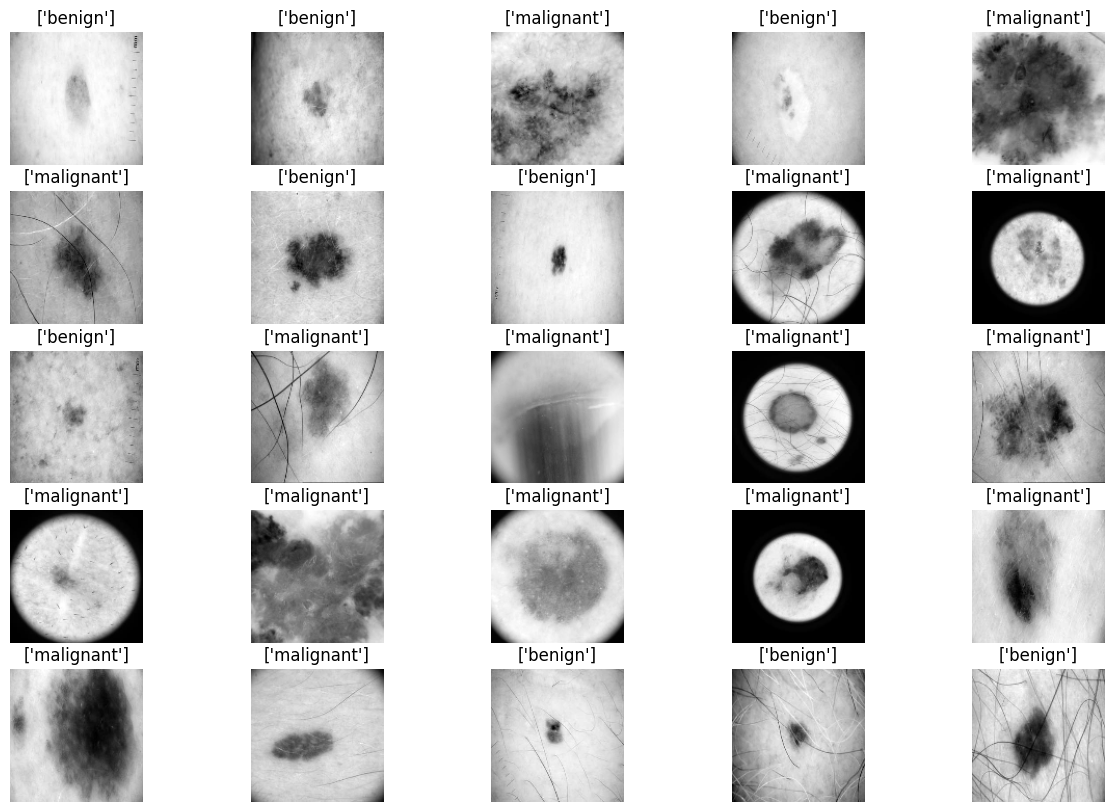

In [15]:
plt.figure(figsize=(15,10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.imshow(test_images[i], cmap='gray')
  plt.title(f"{label_enc.inverse_transform([test_labels[i]])}")
  plt.axis("off")

**CNN Model**

In [16]:
model1 = Sequential()

model1.add(Conv2D(32, (3, 3), input_shape=(128,128,1), activation="leaky_relu"))
model1.add(MaxPool2D(2,2))
model1.add(Conv2D(64, (3, 3), activation="leaky_relu"))
model1.add(MaxPool2D(2,2))
model1.add(Conv2D(128, (3, 3), activation="leaky_relu"))
model1.add(MaxPool2D(2,2))
model1.add(Conv2D(256, (3, 3), activation="leaky_relu"))
model1.add(MaxPool2D(2,2))
model1.add(Flatten())
model1.add(Dense(256, activation="relu"))
model1.add(Dense(1, activation="sigmoid"))

In [17]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0

In [18]:
model1.compile(optimizer="adam", loss="binary_crossentropy", metrics = ['accuracy'])

In [19]:
history1 = model1.fit(train_images, train_labels, validation_data=(test_images, test_labels), epochs=30)

Epoch 1/30
301/301 [==============================] - 19s 22ms/step - loss: 0.4563 - accuracy: 0.7592 - val_loss: 0.3161 - val_accuracy: 0.8510
Epoch 2/30
301/301 [==============================] - 6s 20ms/step - loss: 0.3372 - accuracy: 0.8388 - val_loss: 0.2835 - val_accuracy: 0.8740
Epoch 3/30
301/301 [==============================] - 6s 20ms/step - loss: 0.3141 - accuracy: 0.8531 - val_loss: 0.3062 - val_accuracy: 0.8520
Epoch 4/30
301/301 [==============================] - 6s 20ms/step - loss: 0.2848 - accuracy: 0.8736 - val_loss: 0.2739 - val_accuracy: 0.8770
Epoch 5/30
301/301 [==============================] - 6s 20ms/step - loss: 0.2622 - accuracy: 0.8870 - val_loss: 0.3190 - val_accuracy: 0.8630
Epoch 6/30
301/301 [==============================] - 6s 20ms/step - loss: 0.2553 - accuracy: 0.8905 - val_loss: 0.2891 - val_accuracy: 0.8780
Epoch 7/30
301/301 [==============================] - 6s 20ms/step - loss: 0.2331 - accuracy: 0.9003 - val_loss: 0.2909 - val_accuracy: 0.887

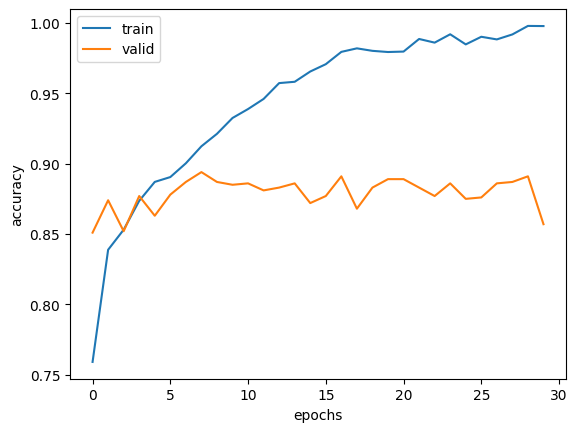

In [20]:
plt.plot(history1.history["accuracy"])
plt.plot(history1.history["val_accuracy"])
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(["train","valid"])
plt.show()

In [21]:
y_pred1 = model1.predict(test_images)

32/32 [==============================] - 0s 8ms/step


In [22]:
y_pred1 = np.where(y_pred1>0.6,1,0)

In [23]:
y_pred1 = y_pred1.reshape(1,-1)[0]

In [24]:
print(classification_report(y_pred1, test_labels))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86       456
           1       0.91      0.83      0.87       544

    accuracy                           0.86      1000
   macro avg       0.86      0.86      0.86      1000
weighted avg       0.87      0.86      0.86      1000



<Axes: >

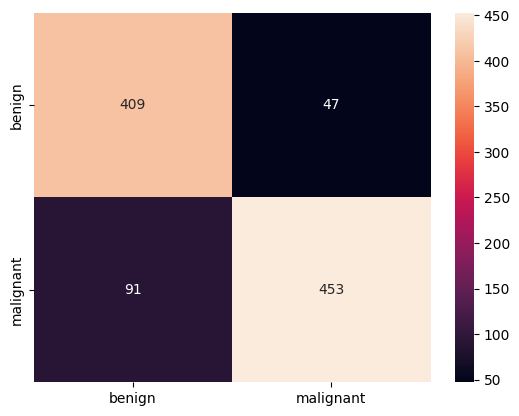

In [25]:
sns.heatmap(confusion_matrix(y_pred1, test_labels), fmt='g', annot=True , xticklabels=["benign", "malignant"], yticklabels=["benign", "malignant"])

**CNN Model with Dropout and GAP Layer**

In [26]:
model2 = Sequential()

model2.add(Conv2D(32, (3,3), input_shape=(128,128,1), activation="leaky_relu"))
model2.add(Dropout(0.1))
model2.add(MaxPool2D(2,2))
model2.add(Conv2D(64, (3,3), activation="leaky_relu"))
model2.add(Dropout(0.2))
model2.add(MaxPool2D(2,2))
model2.add(Conv2D(128, (3,3), activation="leaky_relu"))
model2.add(Dropout(0.3))
model2.add(MaxPool2D(2,2))
model2.add(GlobalAveragePooling2D())
model2.add(Dense(128, activation="leaky_relu"))
model2.add(Dense(1, activation="sigmoid"))

In [27]:
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [28]:
history2 = model2.fit(train_images, train_labels, validation_data=(test_images, test_labels), batch_size=28, epochs=30)

Epoch 1/30
344/344 [==============================] - 13s 31ms/step - loss: 0.5289 - accuracy: 0.7085 - val_loss: 0.5978 - val_accuracy: 0.7430
Epoch 2/30
344/344 [==============================] - 10s 29ms/step - loss: 0.4594 - accuracy: 0.7623 - val_loss: 0.6232 - val_accuracy: 0.6780
Epoch 3/30
344/344 [==============================] - 10s 28ms/step - loss: 0.4378 - accuracy: 0.7753 - val_loss: 0.6603 - val_accuracy: 0.7010
Epoch 4/30
344/344 [==============================] - 10s 29ms/step - loss: 0.4083 - accuracy: 0.7968 - val_loss: 0.6189 - val_accuracy: 0.7050
Epoch 5/30
344/344 [==============================] - 10s 29ms/step - loss: 0.3750 - accuracy: 0.8213 - val_loss: 0.9924 - val_accuracy: 0.6230
Epoch 6/30
344/344 [==============================] - 10s 29ms/step - loss: 0.3705 - accuracy: 0.8265 - val_loss: 0.6504 - val_accuracy: 0.7310
Epoch 7/30
344/344 [==============================] - 10s 28ms/step - loss: 0.3505 - accuracy: 0.8427 - val_loss: 0.6242 - val_accuracy:

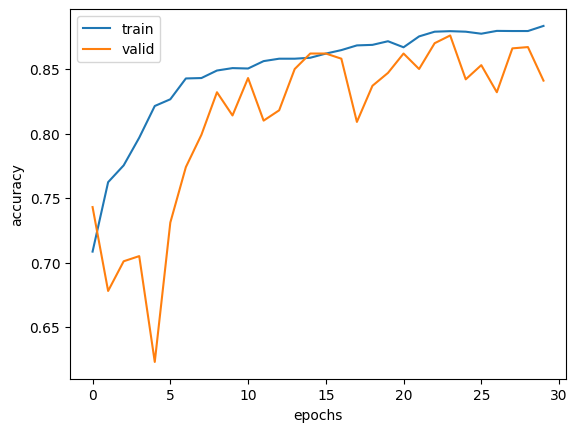

In [29]:
plt.plot(history2.history["accuracy"])
plt.plot(history2.history["val_accuracy"])
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(["train","valid"])
plt.show()

In [30]:
y_pred2 = model2.predict(test_images)

32/32 [==============================] - 0s 7ms/step


In [31]:
y_pred2 = np.where(y_pred2>0.6,1,0)

In [32]:
y_pred2 = y_pred2.reshape(1,-1)[0]

In [33]:
print(classification_report(y_pred2, test_labels))

              precision    recall  f1-score   support

           0       0.81      0.90      0.85       450
           1       0.91      0.82      0.86       550

    accuracy                           0.86      1000
   macro avg       0.86      0.86      0.86      1000
weighted avg       0.86      0.86      0.86      1000



<Axes: >

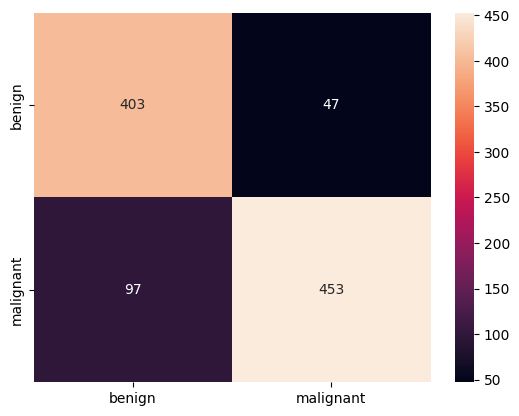

In [34]:
sns.heatmap(confusion_matrix(y_pred2, test_labels), fmt='g', annot=True , xticklabels=["benign", "malignant"], yticklabels=["benign", "malignant"])

**CNN Model GAP and BatchNormlization Layer**

In [35]:
model3 = Sequential()

model3.add(Conv2D(32, (3,3), input_shape=(128,128,1), activation="relu"))
model3.add(BatchNormalization())
model3.add(MaxPool2D(2,2))
model3.add(Conv2D(64, (3,3), activation="relu"))
model3.add(BatchNormalization())
model3.add(MaxPool2D(2,2))
model3.add(Conv2D(128, (3,3), activation="relu"))
model3.add(BatchNormalization())
model3.add(MaxPool2D(2,2))
model3.add(Conv2D(256, (3,3), activation="relu"))
model3.add(BatchNormalization())
model3.add(MaxPool2D(2,2))
model3.add(GlobalAveragePooling2D())
model3.add(Dense(200, activation="leaky_relu"))
model3.add(Dense(1, activation="sigmoid"))

In [36]:
model3.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])

In [37]:
history3 = model3.fit(train_images, train_labels, validation_data=(test_images, test_labels), epochs=30)

Epoch 1/30
301/301 [==============================] - 11s 25ms/step - loss: 0.3797 - accuracy: 0.8228 - val_loss: 0.7430 - val_accuracy: 0.5030
Epoch 2/30
301/301 [==============================] - 7s 23ms/step - loss: 0.3304 - accuracy: 0.8536 - val_loss: 0.5919 - val_accuracy: 0.6890
Epoch 3/30
301/301 [==============================] - 7s 24ms/step - loss: 0.3108 - accuracy: 0.8642 - val_loss: 1.0364 - val_accuracy: 0.6220
Epoch 4/30
301/301 [==============================] - 7s 24ms/step - loss: 0.2991 - accuracy: 0.8708 - val_loss: 0.8754 - val_accuracy: 0.6160
Epoch 5/30
301/301 [==============================] - 7s 23ms/step - loss: 0.2824 - accuracy: 0.8798 - val_loss: 1.4004 - val_accuracy: 0.5950
Epoch 6/30
301/301 [==============================] - 7s 24ms/step - loss: 0.2716 - accuracy: 0.8849 - val_loss: 0.8805 - val_accuracy: 0.7210
Epoch 7/30
301/301 [==============================] - 7s 23ms/step - loss: 0.2683 - accuracy: 0.8846 - val_loss: 0.3770 - val_accuracy: 0.836

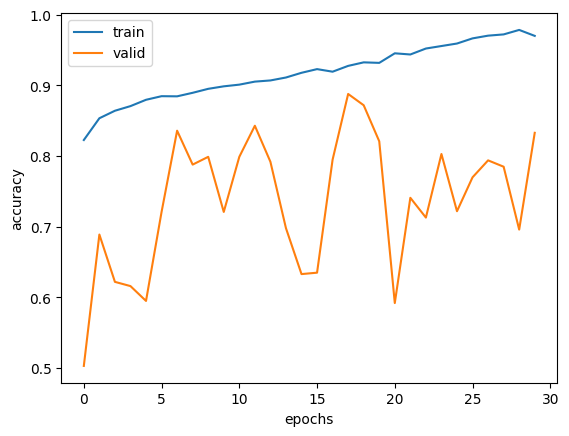

In [38]:
plt.plot(history3.history["accuracy"])
plt.plot(history3.history["val_accuracy"])
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(["train","valid"])
plt.show()

In [39]:
y_pred3 = model3.predict(test_images)

32/32 [==============================] - 0s 7ms/step


In [40]:
y_pred3 = np.where(y_pred3>0.6, 1, 0)

In [41]:
y_pred3 = y_pred3.reshape(1,-1)[0]

In [42]:
print(classification_report(y_pred3, test_labels))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       446
           1       0.90      0.82      0.86       554

    accuracy                           0.85      1000
   macro avg       0.85      0.85      0.85      1000
weighted avg       0.86      0.85      0.85      1000



<Axes: >

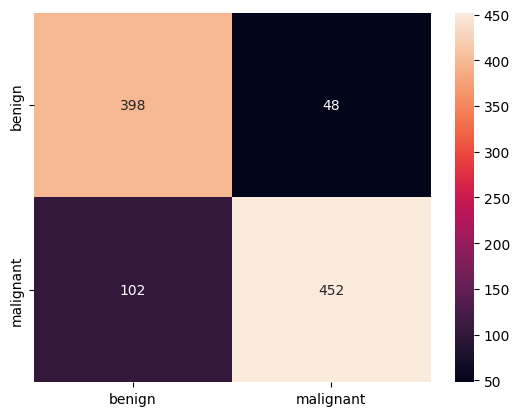

In [43]:
sns.heatmap(confusion_matrix(y_pred3, test_labels), fmt='g', annot=True , xticklabels=["benign", "malignant"], yticklabels=["benign", "malignant"])

**XGBoost Classifier**

In [44]:
xgb_clf = xgb.XGBClassifier()

In [45]:
train_images_xgb = train_images.reshape(train_images.shape[0],-1)
#converting the data into 2D format as ML algorithms cannot work directly on the images so reshaping te data

In [46]:
test_images_xgb = test_images.reshape(test_images.shape[0],-1)

In [47]:
print(f"shape of train images xgb {train_images_xgb.shape}")
print(f"shape of test images xgb {test_images_xgb.shape}")

shape of train images xgb (9605, 16384)
shape of test images xgb (1000, 16384)


In [48]:
xgb_clf.fit(train_images_xgb, train_labels)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [50]:
y_pred4 = xgb_clf.predict(test_images_xgb)

In [51]:
print(f"accuracy of xgboost {accuracy_score(y_pred4, test_labels)}")

accuracy of xgboost 0.905


In [52]:
print(classification_report(y_pred4, test_labels))

              precision    recall  f1-score   support

           0       0.92      0.89      0.91       519
           1       0.89      0.92      0.90       481

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.90      1000
weighted avg       0.91      0.91      0.91      1000



<Axes: >

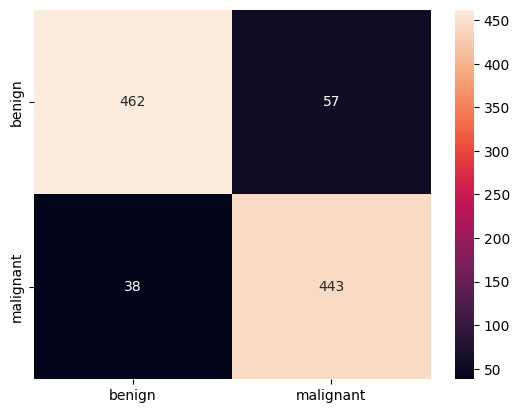

In [53]:
sns.heatmap(confusion_matrix(y_pred4, test_labels), fmt='g', annot=True , xticklabels=["benign", "malignant"], yticklabels=["benign", "malignant"])

**Random Forest Classifier**

In [54]:
rf_clf = RandomForestClassifier()

In [55]:
rf_clf.fit(train_images_xgb, train_labels)

RandomForestClassifier()

In [56]:
y_pred5 = rf_clf.predict(test_images_xgb)

In [57]:
print(f"accuracy of random forest is {accuracy_score(y_pred5, test_labels)}")

accuracy of random forest is 0.903


In [58]:
print(classification_report(y_pred5, test_labels))

              precision    recall  f1-score   support

           0       0.92      0.89      0.90       521
           1       0.88      0.92      0.90       479

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000



<Axes: >

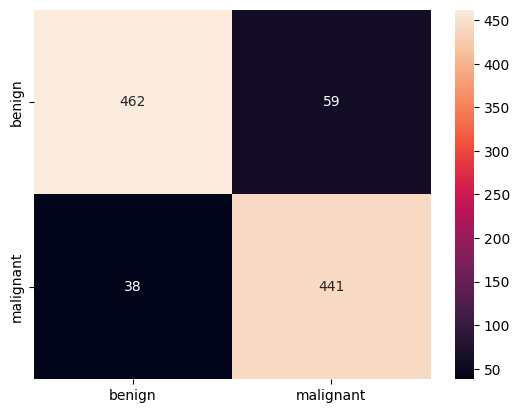

In [59]:
sns.heatmap(confusion_matrix(y_pred5, test_labels), fmt='g', annot=True , xticklabels=["benign", "malignant"], yticklabels=["benign", "malignant"])